# 1- Importing Libraries and Loading Data

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# 2- Transformation of variables

In [26]:
labelencoder = LabelEncoder()
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for col in categorical_columns:
    df[col] = labelencoder.fit_transform(df[col])
    
# prints the new column values
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,Overweight_Level_II


# 3- Dataset Separation

In [27]:
X = df.drop('NObeyesdad', axis=1).values #axis=1 to indicate that a column will be removed
y = labelencoder.fit_transform(df['NObeyesdad'])

# print what value each label takes
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print("relacion")
for label, code in label_mapping.items():
    print(f"{label} -> {code}")

relacion
Insufficient_Weight -> 0
Normal_Weight -> 1
Obesity_Type_I -> 2
Obesity_Type_II -> 3
Obesity_Type_III -> 4
Overweight_Level_I -> 5
Overweight_Level_II -> 6


# 4- Division of the Dataset into Training and Testing

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 5- Decision tree implemantation

## 5.1- Decision node class

In [29]:
# Decision Tree Node
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index #Index of the column to evaluate to divide the dataset
        self.threshold = threshold #range to divide the data(<=)
        self.left = left #Left child node(true)
        self.right = right #Right child node (false)
        self.value = value #Leaf prediction value

## 5.2- class that implements the decision tree

In [30]:
# Decision Tree Implementation
class DecisionTreeClassifierCustom:
    def __init__(self, max_depth, min_samples_split, min_samples_leaf):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    #Train the model
    def train(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape #Number of samples and features
        unique_labels = np.unique(y) #Unique classes

        node_entropy = self._entropy(y) #Entropy of the node
        print(f"Depth: {depth}, Entropy: {node_entropy:.2f}, Samples: {num_samples}")

        # Check termination criteria
        if len(unique_labels) == 1 or depth >= self.max_depth or num_samples < self.min_samples_split or num_samples <= self.min_samples_leaf:
            leaf_value = self._most_common_label(y) #Most common class
            return DecisionNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, num_features)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        # Split the dataset
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return DecisionNode(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y, num_features):
        best_gain = -1 #Best information gain
        split_index, split_threshold = None, None #Best feature and threshold

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                gain = self._information_gain(y, feature_values, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    def _information_gain(self, y, feature_values, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)

        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])

        entropy_left = self._entropy(y[left_indices])
        entropy_right = self._entropy(y[right_indices])

        child_entropy = (n_left / n) * entropy_left + (n_right / n) * entropy_right

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

Depth: 0, Entropy: 2.80, Samples: 1688
Depth: 1, Entropy: 2.33, Samples: 1095
Depth: 2, Entropy: 1.19, Samples: 355
Depth: 3, Entropy: 1.35, Samples: 192
Depth: 4, Entropy: 0.37, Samples: 71
Depth: 5, Entropy: -0.00, Samples: 57
Depth: 5, Entropy: 0.94, Samples: 14
Depth: 6, Entropy: -0.00, Samples: 5
Depth: 6, Entropy: -0.00, Samples: 9
Depth: 4, Entropy: 0.87, Samples: 121
Depth: 5, Entropy: 1.27, Samples: 37
Depth: 6, Entropy: 0.75, Samples: 28
Depth: 7, Entropy: 1.00, Samples: 13
Depth: 8, Entropy: 0.54, Samples: 8
Depth: 8, Entropy: -0.00, Samples: 5
Depth: 7, Entropy: -0.00, Samples: 15
Depth: 6, Entropy: 0.92, Samples: 9
Depth: 7, Entropy: -0.00, Samples: 3
Depth: 7, Entropy: -0.00, Samples: 6
Depth: 5, Entropy: 0.33, Samples: 84
Depth: 6, Entropy: 0.90, Samples: 16
Depth: 7, Entropy: -0.00, Samples: 10
Depth: 7, Entropy: 0.65, Samples: 6
Depth: 6, Entropy: -0.00, Samples: 68
Depth: 3, Entropy: 0.54, Samples: 163
Depth: 4, Entropy: 0.25, Samples: 141
Depth: 5, Entropy: -0.00, Sa

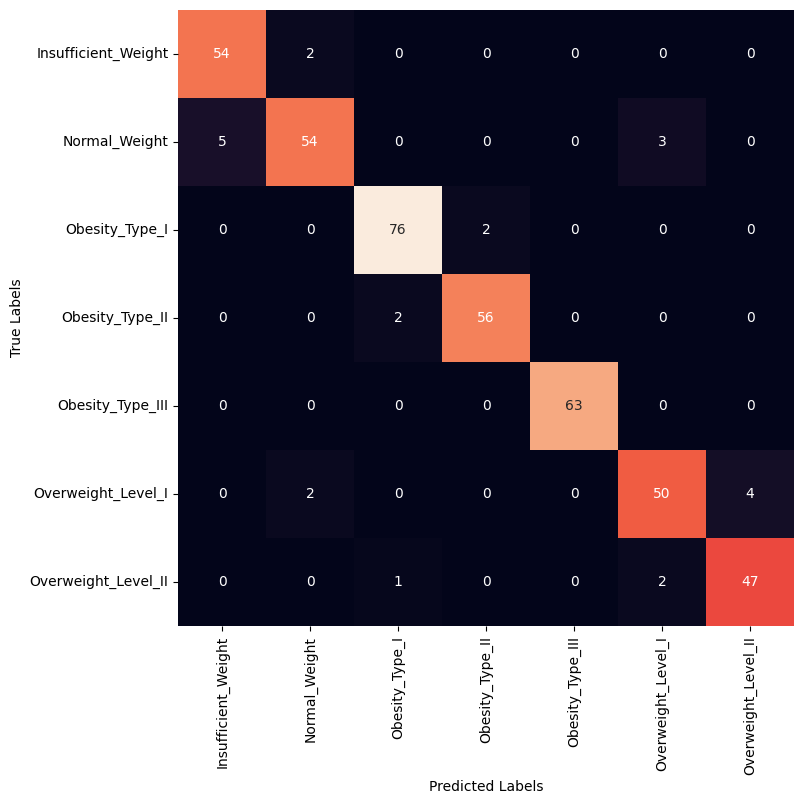


Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        56
           1       0.93      0.87      0.90        62
           2       0.96      0.97      0.97        78
           3       0.97      0.97      0.97        58
           4       1.00      1.00      1.00        63
           5       0.91      0.89      0.90        56
           6       0.92      0.94      0.93        50

    accuracy                           0.95       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.95      0.95       423



In [31]:
# train the model
model = DecisionTreeClassifierCustom(max_depth=8, min_samples_split=7, min_samples_leaf=4)
model.train(X_train, y_train)

# predict the test set
y_pred = model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("----------------------------------------")
print(f'Accuracy of the model: {accuracy:.2f}')
print('\nConfusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(cm, square=True, annot=True, cbar=False)
ax.xaxis.set_ticklabels(labelencoder.classes_, rotation=90)
ax.yaxis.set_ticklabels(labelencoder.classes_, rotation=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()
print('\nReport:')
print(classification_report(y_test, y_pred))


